# Bayesian Monthly Sensitivity Model
## 3 models are tested, with different ways to calculate the standard deviation
$tmp = \Sigma S*dT$ 

$dY \sim N(tmp,1)$

$dY \sim N(tmp,\sqrt{\Sigma S^2 * \sigma_T^2} )$

$dY \sim N(tmp, free\ paramter)$


In [4]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import stan
import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [5]:
states=['Indiana','Illinois']

In [6]:
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    temp_states.append(maize_temp)
temp_states=pd.concat(temp_states,keys=states)

In [8]:
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [10]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,1:]).reshape(len(states),int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)
}

In [11]:
# Compile model, for N(tmp,1)
with open('stan/BMSM-simp.stan', 'r') as f:
    model = f.read()

sm=stan.build(model, data) # reads in the stan model wit sigma = 1

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_8ls7lxt3/model_2wdzshqy.stan', line 28, column 24: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [13]:
fit=sm.sample(num_chains=4,num_samples=1000)

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  38% (3000/8000)
Sampling:  59% (4700/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000175 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000174 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000158 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000164 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.64 seconds.
  Adjust your expectations accordingly!


In [14]:
df = fit.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-29.731294,3.492382,-50.837370,-31.938111,-29.379737,-27.148471,-20.841257
accept_stat__,4000.0,0.877195,0.114401,0.336758,0.814672,0.907450,0.970728,1.000000
stepsize__,4000.0,0.431716,0.021460,0.397946,0.421620,0.437122,0.447217,0.454673
treedepth__,4000.0,3.215250,0.411047,3.000000,3.000000,3.000000,3.000000,4.000000
n_leapfrog__,4000.0,10.533000,4.241510,7.000000,7.000000,7.000000,15.000000,31.000000
...,...,...,...,...,...,...,...,...
d_yields_pred.1.34,4000.0,0.730597,1.109278,-3.153666,-0.015435,0.743467,1.485232,4.757783
d_yields_pred.2.34,4000.0,0.876235,1.114338,-3.831852,0.116234,0.874629,1.629747,5.224385
d_yields_pred.1.35,4000.0,1.281636,1.165590,-2.800642,0.504998,1.258544,2.060313,5.227879


In [9]:
samples=fit.extract()

In [16]:
# Results Edward Pope, linear fit for 'Indiana'

arr = [np.nan,np.nan,np.nan,0.0862453406310437,0.0232350785672767,-0.118245529967667,
       -0.443216771777978,-0.200990287316511,0.0590919010412627,-0.000147094860475441,np.nan,np.nan]
dT_all_states= np.array(temp_states.iloc[:,1:]).reshape(len(states),int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)

dT = dT_all_states[0,:,:]
aT = np.zeros(35)

arr = np.array(arr)
use = np.isfinite(arr)
arr[~use] = 0.0
for i in range(np.size(aT)):
    aT[i] = np.sum(arr*dT[i,:])

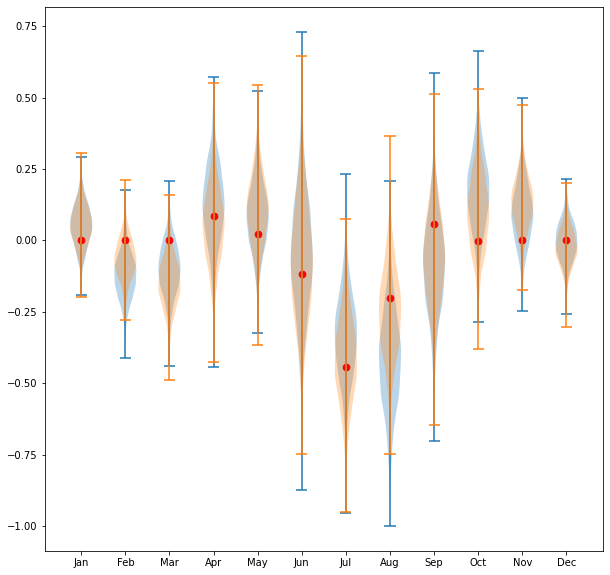

In [17]:
# violin plot for Indiana Illinois
plt.figure(figsize=(10,10))
plt.violinplot(fit['s_temp'].T[:,:,0]);
plt.violinplot(fit['s_temp'].T[:,:,1]);
plt.xticks(range(1,13),maize_temp.columns[1:]);
plt.scatter(range(1,13),arr, color = 'red', s = 45);
plt.show()

In [19]:
fit['d_yields_pred'].T.shape

(4000, 35, 2)

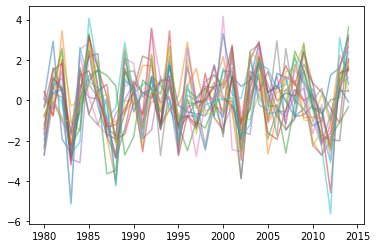

In [20]:
for s in range(0,2000,100):
    plt.plot(range(1980,2015),fit['d_yields_pred'].T[s,:,0].T,alpha=0.5)

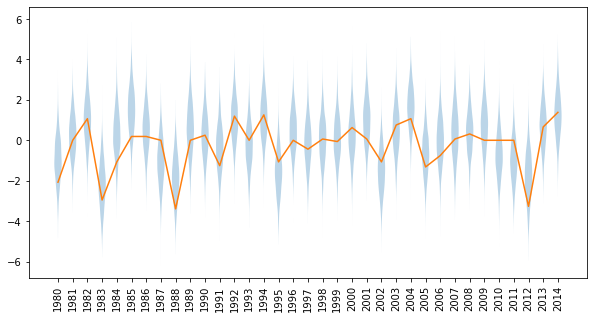

In [22]:
# orange is true results, and blue are the histograms of the output from stan fo 'Indiana'
plt.figure(figsize=(10,5))
plt.violinplot(fit['d_yields_pred'].T[:,:,0],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),data['d_yields'][0,:])


In [26]:
data['d_yields'].shape

(2, 35)

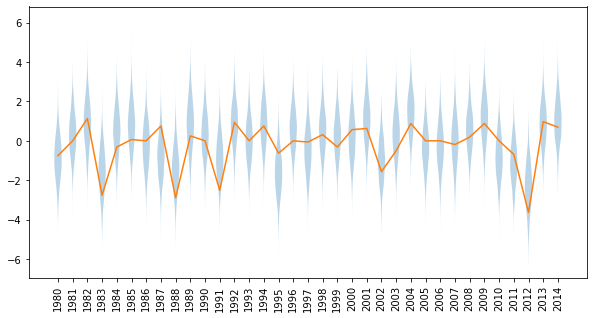

In [27]:
# results for 'Illinois'
plt.figure(figsize=(10,5))
plt.violinplot(fit['d_yields_pred'].T[:,:,1],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),data['d_yields'][1,:])


In [29]:
data_T= np.array(temp_states.iloc[:,1:]).reshape(len(states),int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)

# calculate the standard deviation in T over the years per month, in this case for two states
sigma_T = np.zeros([np.size(states),12])

for i in range(np.size(states)):
    sigma_T[i,:] = np.std(data_T[i,:,:],axis = 0)


In [30]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,1:]).reshape(len(states),int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float),
    'var_temp':sigma_T**2
}

In [31]:
with open('stan/BMSM-simp_SD.stan', 'r') as f:
    model = f.read()

sm_SD=stan.build(model, data) # stan model with sigma = \sqrt{\Sigma S^2 * \sigma_T^2}
# reads in var(T) as extra parameter, 

Building...



Building: 18.4s, done.Messages from stanc:
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_a2ednf8x/model_n7ms2fgz.stan', line 35, column 24: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [32]:
fit2=sm_SD.sample(num_chains=4,num_samples=1000) # fit to the second model

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   8% (600/8000)
Sampling:  14% (1100/8000)
Sampling:  21% (1700/8000)
Sampling:  44% (3500/8000)
Sampling:  64% (5100/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


In [33]:
df = fit2.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-27.988495,4.591213,-48.573818,-30.711348,-27.555646,-24.741451,-16.258695
accept_stat__,4000.0,0.904802,0.107816,0.055390,0.864296,0.940204,0.982270,1.000000
stepsize__,4000.0,0.357327,0.018775,0.338021,0.339230,0.355511,0.373608,0.380267
treedepth__,4000.0,3.652250,0.476316,3.000000,3.000000,4.000000,4.000000,4.000000
n_leapfrog__,4000.0,13.384000,3.561982,7.000000,15.000000,15.000000,15.000000,31.000000
...,...,...,...,...,...,...,...,...
d_yields_pred.1.34,4000.0,0.563326,1.077585,-3.821376,-0.144175,0.555372,1.285625,4.224574
d_yields_pred.2.34,4000.0,0.769160,1.054282,-4.006774,0.072035,0.778141,1.471599,5.053838
d_yields_pred.1.35,4000.0,1.139914,1.188876,-3.678560,0.337610,1.097723,1.932667,7.044561


In [21]:
samples2=fit2.extract()


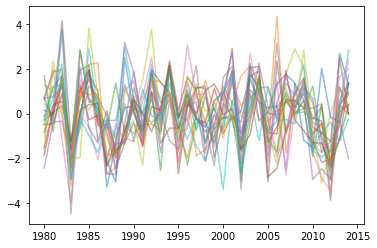

In [45]:
for s in range(0,2000,100):
    plt.plot(range(1980,2015),fit2['d_yields_pred'].T[s,:,0],alpha=0.5)

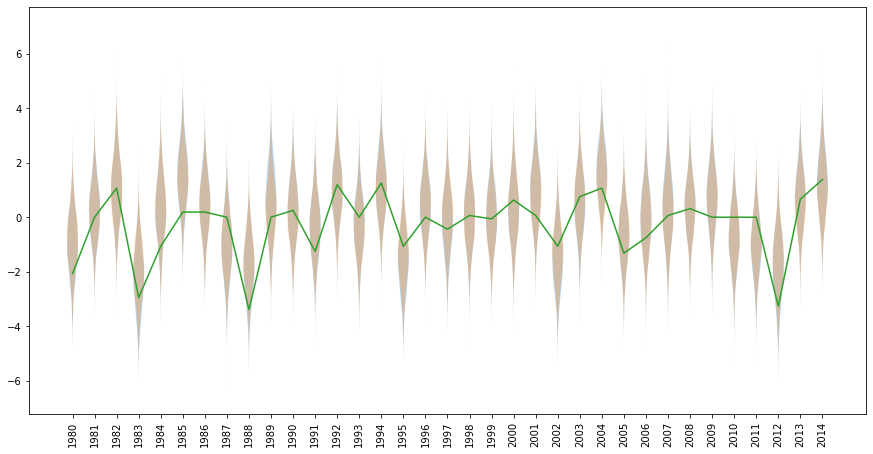

In [46]:
plt.figure(figsize=(15,7.5))
plt.violinplot(fit['d_yields_pred'].T[:,:,0],showextrema=False);
plt.violinplot(fit2['d_yields_pred'].T[:,:,0],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),data['d_yields'][0,:])

In [47]:
print(np.sqrt(np.sum(np.mean(fit2['s_temp'].T[:,:,0],axis = 0)**2*data_T[0,:]**2)))

#print(np.mean(samples['s_temp'][:,0,:],axis = 0))

4.640847771871783


In [42]:
with open('stan/free_stan.stan', 'r') as f:
    model = f.read()
sm3=stan.build(model, data)

Building...



Building: 19.7s, done.Messages from stanc:
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_o08ju0p6/model_mrj6e3t5.stan', line 37, column 24: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [43]:
fit3=sm3.sample(num_chains=4,num_samples=1000)

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  21% (1700/8000)
Sampling:  42% (3400/8000)
Sampling:  62% (5000/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!


In [44]:
# fit3
df = fit3.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-28.246761,4.653796,-56.985259,-31.191712,-27.745684,-24.891083,-16.673185
accept_stat__,4000.0,0.868141,0.127697,0.307258,0.800693,0.907403,0.969038,1.000000
stepsize__,4000.0,0.404447,0.011633,0.390471,0.394480,0.404380,0.414348,0.418558
treedepth__,4000.0,3.325500,0.468620,3.000000,3.000000,3.000000,4.000000,4.000000
n_leapfrog__,4000.0,11.468000,4.349909,7.000000,7.000000,15.000000,15.000000,31.000000
...,...,...,...,...,...,...,...,...
d_yields_pred.1.34,4000.0,0.724287,1.051940,-3.451837,0.033901,0.719033,1.413656,4.722591
d_yields_pred.2.34,4000.0,0.896331,1.046596,-3.621141,0.204126,0.883321,1.599455,4.640666
d_yields_pred.1.35,4000.0,1.282341,1.099254,-2.634133,0.545867,1.268068,1.997074,5.690284


In [29]:
samples3=fit3.extract()


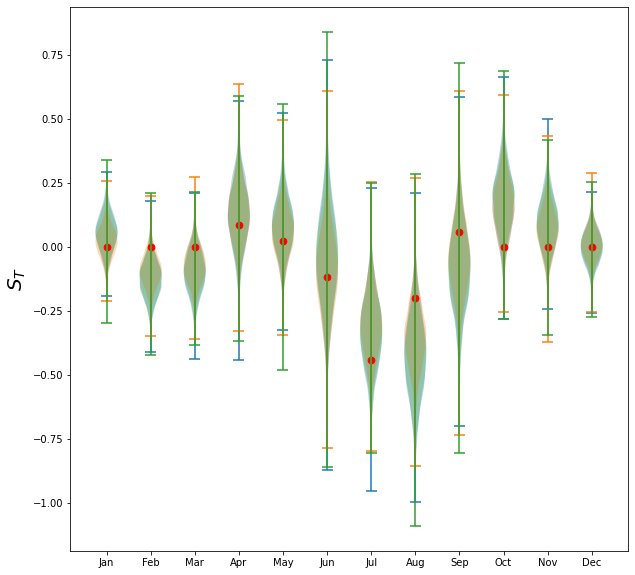

In [48]:
plt.figure(figsize=(10,10)) # violinplot for the 3 models, plus the linear fitting in red for 'Indiana'
plt.violinplot(fit['s_temp'].T[:,:,0]);
plt.violinplot(fit2['s_temp'].T[:,:,0]);
plt.violinplot(fit3['s_temp'].T[:,:,0]);

plt.ylabel('$S_T$', size = 20)


plt.scatter(range(1,13),arr, color = 'red', s = 45);
plt.xticks(range(1,13),maize_temp.columns[1:]);

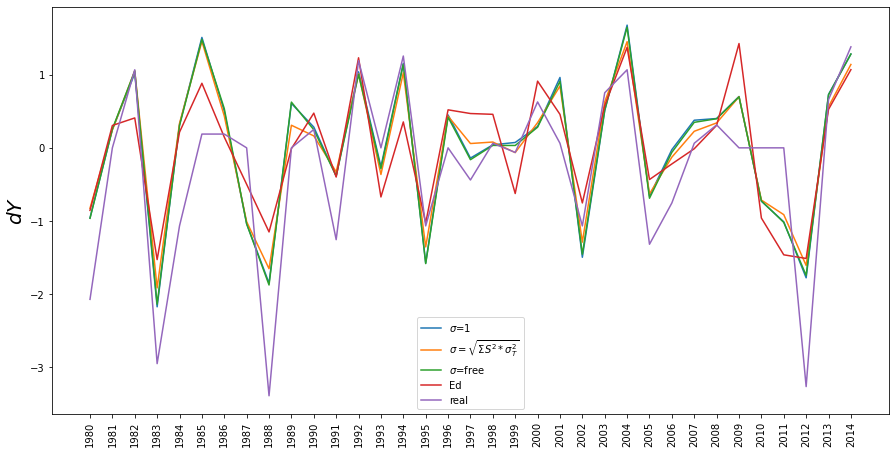

93.56026942888433
92.52001621467784
88.34778854943967
91.60212681004253


In [52]:
plt.figure(figsize=(15,7.5))
#plt.violinplot(samples['d_yields_pred'][:,0,:],showextrema=False);
#plt.violinplot(samples2['d_yields_pred'][:,0,:],showextrema=False);
#plt.violinplot(samples3['d_yields_pred'][:,0,:],showextrema=False);
plt.plot(range(1,36), np.mean(fit['d_yields_pred'].T[:,:,0],axis = 0) , label = '$\sigma$=1')
plt.plot(range(1,36), np.mean(fit2['d_yields_pred'].T[:,:,0],axis = 0), label = '$\sigma=\sqrt{\Sigma S^2 * \sigma_T^2}$' )
plt.plot(range(1,36), np.mean(fit3['d_yields_pred'].T[:,:,0],axis = 0), label = '$\sigma$=free' )
plt.plot(range(1,36), aT, label = 'Ed' )

plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),data['d_yields'][0,:], label = 'real')
plt.ylabel('$dY$', size = 20)

plt.legend()
plt.show()

#the sum of the square deviations of the 3 models 
print(np.sum(np.mean(fit['d_yields_pred'].T[:,:,0],axis = 0)-data['d_yields'][0,:])**2)
print(np.sum(np.mean(fit2['d_yields_pred'].T[:,:,0],axis = 0)-data['d_yields'][0,:])**2)
print(np.sum(np.mean(fit3['d_yields_pred'].T[:,:,0],axis = 0)-data['d_yields'][0,:])**2)
print(np.sum(aT-data['d_yields'][0,:])**2)


In [50]:
dataT= np.array(temp_states.iloc[:,1:]).reshape(len(states),int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)
print(np.std(dataT[0,:,:],axis =1 ))


[1.62304477 1.22202291 2.43224907 2.30350168 2.47063071 2.25650395
 1.1436583  1.42217752 1.49793652 2.48964782 1.94539362 1.3923486
 1.6249934  1.23524549 1.93118171 1.55261971 1.37654308 1.47121967
 1.61794042 1.42775158 2.46330974 1.64528983 1.80111558 1.507469
 1.31814651 1.55541663 2.1763036  2.52537362 0.94317458 1.63662923
 1.92881466 1.4655299  2.13457324 1.25828224 2.02089666]
